In [1]:
import open_clip
import torch
from PIL import Image

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import shutil
from tqdm import tqdm
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler


/home/raph/fast_mem/anaconda3/envs/BeautyPredict/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device="cuda:0"

In [3]:
full_set = pd.read_csv("full_set.csv")

In [4]:
name = "open_clip_ViT-B-32"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

tokenizer = open_clip.get_tokenizer('ViT-B-32')

model.to(device)

KeyboardInterrupt: 

In [21]:
# сохранение всех эмбеддингов
ids = []
img_embs = []
text_embs = []

img_emb_df = pd.DataFrame()
text_emb_df = pd.DataFrame()
both_emb_df = pd.DataFrame()


for index, row in tqdm(full_set.iterrows()):
    img = preprocess(Image.open(row["img_path"])).unsqueeze(0).to(device)
    promt = tokenizer(row["img_generation_promt"]).to(device)
    
    
    
    with torch.no_grad():
        
        img_emb = model.encode_image(img)
        text_emb = model.encode_text(promt)
        both_emb = torch.cat([img_emb, text_emb], axis=1)

    img_column_names = [f'emb{i}' for i in range(img_emb.size(1))]
    img_tmp_df = pd.DataFrame(img_emb.cpu().numpy(), columns=img_column_names, dtype="float16")
    img_tmp_df["id"] = row["id"]
    img_emb_df = pd.concat([img_emb_df, img_tmp_df])
    
    
    text_column_names = [f'emb{i}' for i in range(text_emb.size(1))]
    text_tmp_df = pd.DataFrame(text_emb.cpu().numpy(), columns=text_column_names, dtype="float16")
    text_tmp_df["id"] = row["id"]
    text_emb_df = pd.concat([text_emb_df, text_tmp_df])
    
    both_column_names = [f'emb{i}' for i in range(both_emb.size(1))]
    both_tmp_df = pd.DataFrame(both_emb.cpu().numpy(), columns=both_column_names, dtype="float16")
    both_tmp_df["id"] = row["id"]
    both_emb_df = pd.concat([both_emb_df, both_tmp_df])

    
img_emb_df = img_emb_df[["id", *img_column_names]]
img_emb_df.to_csv(os.path.join(emb_dir, name + "_img.csv"), index=False)

text_emb_df = text_emb_df[["id", *text_column_names]]
text_emb_df.to_csv(os.path.join(emb_dir, name + "_text.csv"), index=False)

both_emb_df = both_emb_df[["id", *both_column_names]]
both_emb_df.to_csv(os.path.join(emb_dir, name + "_both.csv"), index=False)


2256it [03:24, 11.04it/s]


In [5]:
def create_tsne(df):
    # Select the numerical columns from the DataFrame
    numerical_columns = df.select_dtypes(include=[np.float64])

    # Perform T-SNE on the numerical columns
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(numerical_columns)
    
    return tsne, tsne_results

In [7]:
def capture_tsne(tsne_df, df):
    # Optional: If you have labels or categories in your DataFrame, you can include them in the T-SNE DataFrame
    tsne_df['label'] = df['label']

    # Visualize the T-SNE results
    for label in tsne_df["label"].unique():
        plt.scatter(
            tsne_df["TSNE1"][tsne_df["label"]==label],
            tsne_df["TSNE2"][tsne_df["label"]==label],
            label=label
        )
    
    plt.xlabel('TSNE1')
    plt.ylabel('TSNE2')
    plt.title('T-SNE Visualization')
    plt.legend()
    
    plt.show()

In [28]:
def save_clusters_by_column2(df, dst, cluster_col, cluster_nums):
    if not os.path.exists(dst):
        os.makedirs(dst)
    else:
        shutil.rmtree(dst)
        os.makedirs(dst)
    
    means = []
    stds = []
    nums = {
        0: [],
        1: [],
        2: [],
        3: []
    }
    
    for cluster_num in cluster_nums:
        cl_df = df[cluster_col==cluster_num]
        cl_rating_df = cl_df["rating"]
        
        for i in range(4):
            nums[i].append(cl_df[cl_rating_df == i]["id"].count())
            
        
        cl_mean = cl_rating_df.mean()
        cl_std = cl_rating_df.std()
        
        means.append(cl_mean)
        stds.append(cl_std)
        
        cl_dir_name = str(cluster_num) + f"[mean_{cl_mean}][std_{cl_std}]"
        cl_dir_path = os.path.join(dst, cl_dir_name)
        
        os.mkdir(os.path.join(dst, cl_dir_name))
        cl_df = df[cluster_col==cluster_num]
        cl_df[["id", "rating", "img_generation_promt"]].to_csv(os.path.join(cl_dir_path, "cl_info.csv"), index=False)
        for index, row in cl_df.iterrows():
            shutil.copyfile(row["img_path"], os.path.join(cl_dir_path, 
                                                          os.path.basename(row["img_path"])+f"[{row['rating']}]"))
        
    return pd.DataFrame({
        "cluster": cluster_nums,
        "mean": means,
        "std": stds,
        **nums
    })

In [9]:
emb_dir = "embeddings"
ill_dir = "t_sne_illustrations"

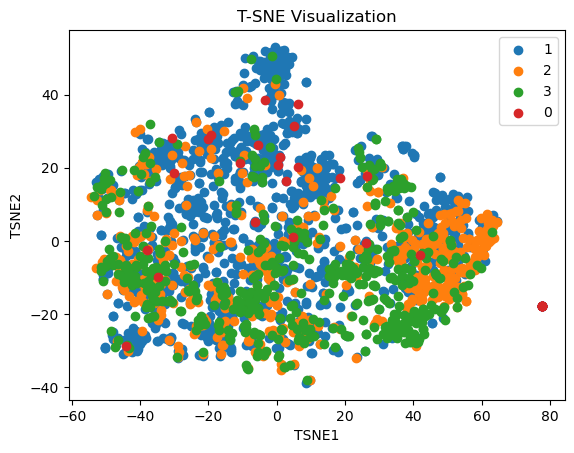

In [15]:
name = "open_clip_ViT-B-32_img"

df = pd.read_csv(os.path.join(emb_dir, f"{name}.csv"))

merged_df = full_set[["id", "rating"]].merge(df, on="id").rename(
    {
        "rating": "label"
    }, axis=1)

tsne, tsne_results = create_tsne(merged_df)

tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

capture_tsne(tsne_df, merged_df)

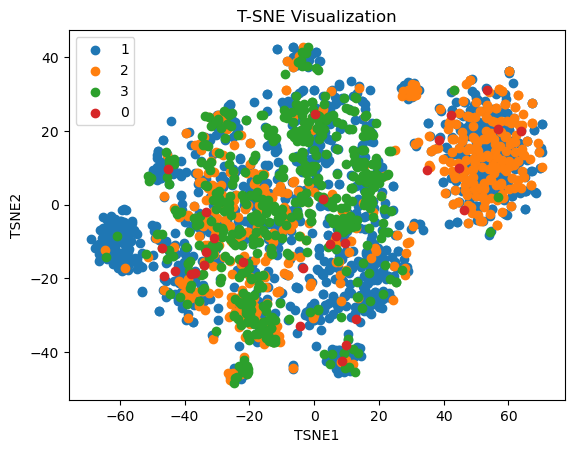

In [21]:
name = "open_clip_ViT-B-32_text"

df = pd.read_csv(os.path.join(emb_dir, f"{name}.csv"))

merged_df = full_set[["id", "rating"]].merge(df, on="id").rename(
    {
        "rating": "label"
    }, axis=1)

tsne, tsne_results = create_tsne(merged_df)

tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

capture_tsne(tsne_df, merged_df)

/tmp/ipykernel_8216/786357566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsne_df['label'] = df['label']


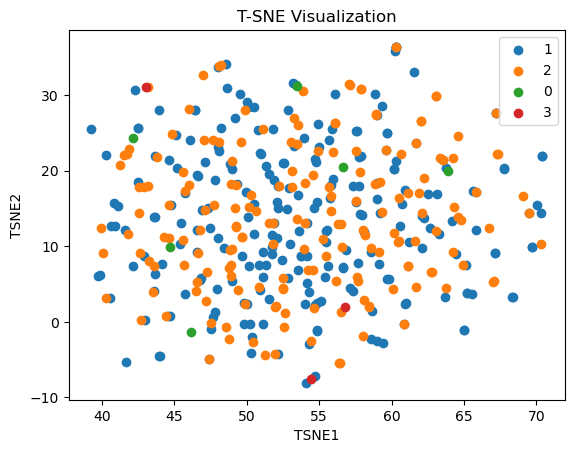

In [22]:
capture_tsne(tsne_df[tsne_df["TSNE1"]>39], merged_df[tsne_df["TSNE1"]>39])

Text(0.5, 1.0, 'KMeans Clustering')

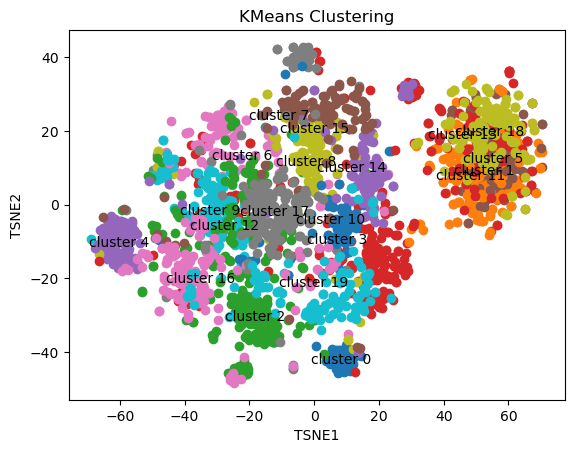

In [26]:
# Train KMeans on the numerical columns
n_clusters=20
kmeans = KMeans(n_clusters=n_clusters, n_init="auto", max_iter=1000, random_state=0)
clusters = kmeans.fit_predict(merged_df.select_dtypes(include=[np.float64]))

# Create a new DataFrame with the cluster labels
cluster_df = pd.DataFrame(clusters, columns=['cluster'])

combined_df = pd.concat([tsne_df, cluster_df], axis=1)
centroids = combined_df.groupby('cluster').mean()

cl_promt_df = pd.DataFrame({
    "id": full_set["id"],
    "cl": clusters,
    "promt": full_set["img_generation_promt"]
})

scatter = []
for cluster in centroids.index:
    cluster_data = combined_df[combined_df['cluster'] == cluster]

    
    scatter.append(plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'cluster {cluster}'))

    centroid = centroids.loc[cluster]
    plt.annotate(f'cluster {cluster}', (centroid['TSNE1'], centroid['TSNE2']),
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=10, color='black')

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('KMeans Clustering')


In [29]:
save_clusters_by_column2(full_set, os.path.join("clusters", name, "KMeans"), 
               combined_df['cluster'], 
               range(n_clusters))

,cluster,mean,std,0,1,2,3
0,0,1.245283,0.704536,2,42,3,6
1,1,1.397727,0.515055,1,51,36,0
2,2,2.225610,0.801274,1,35,54,74
3,3,1.427835,0.732268,0,139,27,28
4,4,1.047619,0.290257,0,102,1,2
5,5,1.351648,0.524375,2,55,34,0
6,6,1.704762,0.876222,0,60,16,29
7,7,1.589286,0.804008,0,34,11,11
8,8,2.087591,0.973732,0,59,7,71
9,9,1.819444,0.816378,2,57,50,35


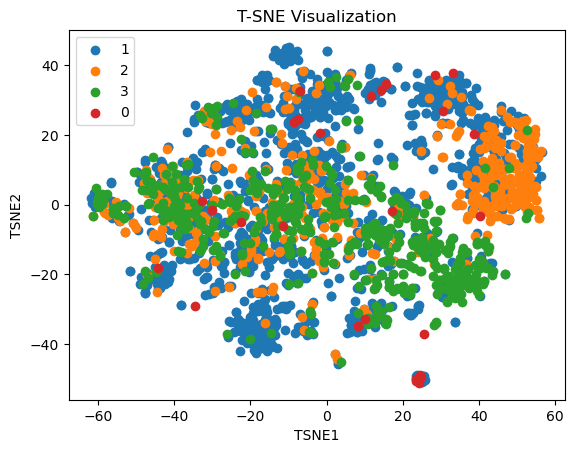

In [18]:
name = "open_clip_ViT-B-32_both"

df = pd.read_csv(os.path.join(emb_dir, f"{name}.csv"))

merged_df = full_set[["id", "rating"]].merge(df, on="id").rename(
    {
        "rating": "label"
    }, axis=1)

tsne, tsne_results = create_tsne(merged_df)

tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

capture_tsne(tsne_df, merged_df)